# About the Dataset:

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.
Develop a machine learning model to predict whether customer left the bank using the features provided in the dataset. Prior to building the ML model EDA needs to carried out to understand and clean the data.         


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score,KFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from scipy import stats
from sklearn.metrics import classification_report,roc_curve,confusion_matrix,accuracy_score,recall_score,precision_score,f1_score

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

### Data Understanding

In [4]:
df=pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.shape

(10000, 14)

In [6]:
df = df.drop(['RowNumber', 'CustomerId','Surname'], axis=1) #These features are not helping for the model

In [7]:
df.shape

(10000, 11)

In [8]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [9]:
print('The number of numeric columns', df.select_dtypes(include=np.number).shape[1])
print('The number of categorical columns', df.select_dtypes(exclude=np.number).shape[1])

The number of numeric columns 9
The number of categorical columns 2


In [10]:
df[['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


In [11]:
df[['Geography','Gender']].describe()

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [12]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [13]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [14]:
# as these columns are nominal and also have only few levels, one hot encoding is preferable

In [15]:
df=pd.get_dummies(df,columns=['Geography','Gender'], drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [16]:
df.shape

(10000, 12)

In [17]:
df.isnull().sum().sum()

0

### Data Preparation 

In [18]:
# No missing values is present 

In [19]:
#Check for outliers 

In [20]:
numeric=df[['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']]

In [21]:
numeric.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,619,42,2,0.00,1,101348.88
1,608,41,1,83807.86,1,112542.58


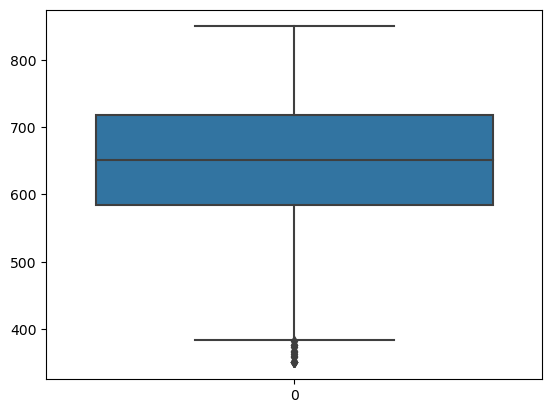

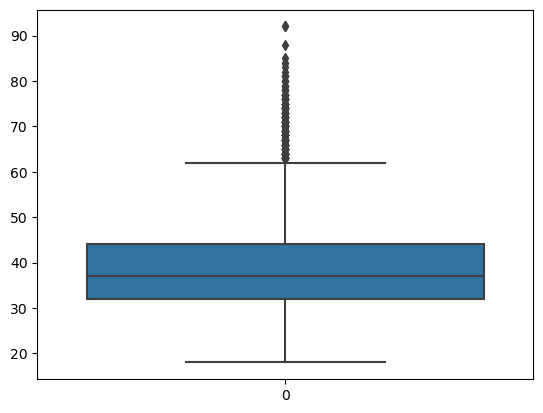

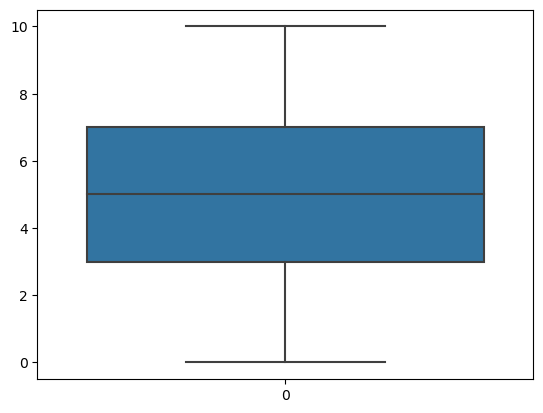

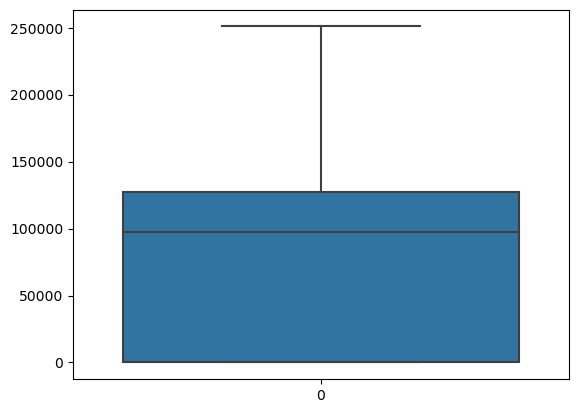

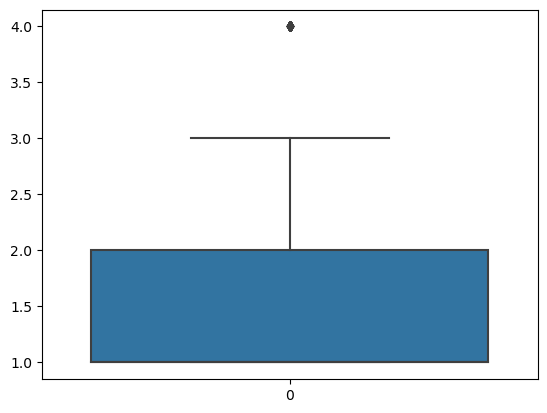

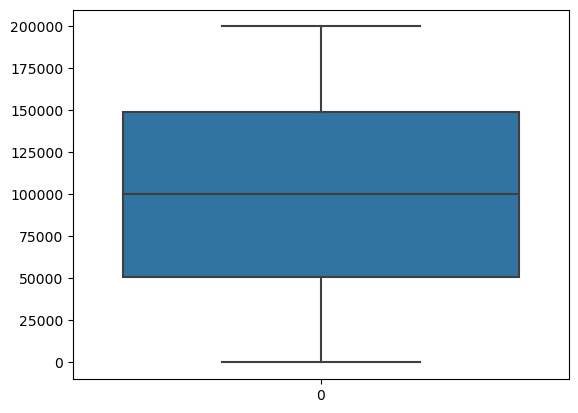

In [22]:
import seaborn as sb
for i in numeric.columns:
    sb.boxplot(numeric[i])
    plt.show()

In [23]:
#Outliers are present 

In [24]:
# Removing outliers using z-score method

In [25]:
q1 = df['Age'].quantile(0.25)
q3 = df['Age'].quantile(0.75)
iqr = q3 - q1
ub = q3 + 1.5*iqr
lb = q1 - 1.5*iqr
df = df[~(df['Age']>ub)]

In [26]:
q1 = df['CreditScore'].quantile(0.25)
q3 = df['CreditScore'].quantile(0.75)
iqr = q3 - q1
ub = q3 + 1.5*iqr
lb = q1 - 1.5*iqr
df = df[~(df['CreditScore']<lb)]

In [27]:
df.shape

(9627, 12)

In [28]:
# from scipy import stats
# import numpy as np
# z = np.abs(stats.zscore(df[['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']]))
# print(z)

In [29]:
#df =df[(z < 3).all(axis=1)]

In [30]:
df.shape

(9627, 12)

In [31]:
df.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0


In [32]:
df.isnull().sum().sum()

0

In [33]:
df.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [34]:
df['Exited'].value_counts() # Target column is not balanced

0    7677
1    1950
Name: Exited, dtype: int64

In [35]:
# correlation is effective only for continous numeric variable


In [36]:
cor = df[['CreditScore','Age','Tenure','Balance','EstimatedSalary']].corr()
#cor

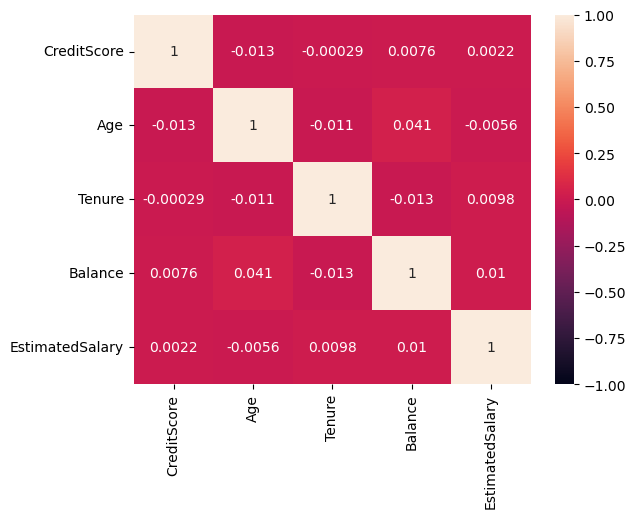

In [37]:
sns.heatmap(cor, annot = True,vmin=-1,vmax=1)
plt.show()

In [38]:
## All the numeric input columns are independent of each other

In [39]:
x=df.drop(['Exited'],axis=1)
y=df['Exited']

In [40]:
from sklearn.model_selection import train_test_split
# Splitting the data into train and test
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2,
                                                random_state=10)

### Model Building 

In [41]:
# create an empty dataframe to store the scores for various algorithms
perf_score = pd.DataFrame(columns=["Model", "Accuracy","Recall",
                                   "Precision","F1 Score"] )

In [42]:
def per_measures(model,test,pred):
    accuracy    = accuracy_score(test,pred)
    f1score     = f1_score(test,pred)
    recall      = recall_score(test,pred)
    precision   = precision_score(test,pred)
    # reliability = cohen_kappa_score(test,pred)
    return (accuracy,recall,precision,f1score,)

In [43]:
def update_performance (name, model,test,pred):
    # assign 'comp_perf' as global variable
    global perf_score


    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    perf_score = perf_score.append({'Model'       : name,
                                    'Accuracy'    : per_measures(model,test,pred)[0],
                                    'Recall'      : per_measures(model,test,pred)[1],
                                    'Precision'   : per_measures(model,test,pred)[2],
                                    'F1 Score'    : per_measures(model,test,pred)[3]
                                    # 'AIC'         : per_measures(model,ytest,ypred)[4],
                                    # 'Reliability' : per_measures(model,ytest,ypred)[5]

                                     },
                                   ignore_index = True)

In [44]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(xtrain, ytrain)

LogisticRegression()

In [45]:
coef_logit=lr.coef_
#coef_logit

In [46]:
coef_odd=np.exp(coef_logit)
#coef_odd

In [47]:
#list(xtrain.columns)

In [48]:
res=pd.DataFrame({'Feature':xtrain.columns,
                  'Logit':coef_logit[0],
                  'odd_ratio':coef_odd[0]})
res

,Feature,Logit,odd_ratio
0,CreditScore,-2.552706e-03,0.997451
1,Age,-6.210542e-05,0.999938
2,Tenure,-2.028925e-05,0.999980
3,Balance,4.438019e-06,1.000004
4,NumOfProducts,-6.675935e-06,0.999993
5,HasCrCard,-2.869733e-06,0.999997
6,IsActiveMember,-3.789175e-06,0.999996
7,EstimatedSalary,-4.254925e-07,1.000000
8,Geography_Germany,1.264225e-06,1.000001
9,Geography_Spain,-1.731350e-06,0.999998


One unit increase in Credit score, will decrease the Odds of getting exited by 0.99 times

One unit increase in Age, will increase the Odds of getting exited by 1.05 times

In [49]:
ypred_lr=lr.predict(xtest)
print(classification_report(ytest,ypred_lr))
print(confusion_matrix(ytest,ypred_lr))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      1554
           1       0.00      0.00      0.00       372

    accuracy                           0.81      1926
   macro avg       0.40      0.50      0.45      1926
weighted avg       0.65      0.81      0.72      1926

[[1554    0]
 [ 372    0]]


In [50]:
update_performance(name = 'LogisticReg-Base', 
                   model = lr,
                   test=ytest,
                   pred=ypred_lr)
# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.0,0.0,0.0


In [51]:
knn = KNeighborsClassifier()
knn.fit(xtrain,ytrain)
ypred_knn = knn.predict(xtest)

In [52]:
update_performance(name = 'KNN-Base', model = knn,test=ytest,pred=ypred_knn)
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.00000,0.000000,0.000000
1,KNN-Base,0.762201,0.08871,0.217105,0.125954


### Decision Tree

In [53]:
dt = DecisionTreeClassifier(random_state=10)
dt.fit(xtrain,ytrain)
ypred_dt = dt.predict(xtest)

In [54]:
update_performance(name = 'Decision Tree-Gini', model = dt,test=ytest,
                   pred=ypred_dt)
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308


In [55]:
dt_e = DecisionTreeClassifier(criterion='entropy',random_state=10)
dt_e.fit(xtrain,ytrain)
ypred_dt_e = dt_e.predict(xtest)

print(accuracy_score(ytest,ypred_dt_e))
print(confusion_matrix(ytest,ypred_dt_e))
print(classification_report(ytest,ypred_dt_e))

0.7902388369678089
[[1343  211]
 [ 193  179]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1554
           1       0.46      0.48      0.47       372

    accuracy                           0.79      1926
   macro avg       0.67      0.67      0.67      1926
weighted avg       0.79      0.79      0.79      1926



**Summarize the Decision Tree using Criterion as Entropy**

In [56]:
update_performance(name = 'Decision Tree-Entropy', model = dt_e,test=ytest,pred=ypred_dt_e)
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816


In [57]:
feature_imp = pd.DataFrame()
feature_imp['Feature']=xtrain.columns
feature_imp['Importance']=dt.feature_importances_

In [58]:
#feature_imp

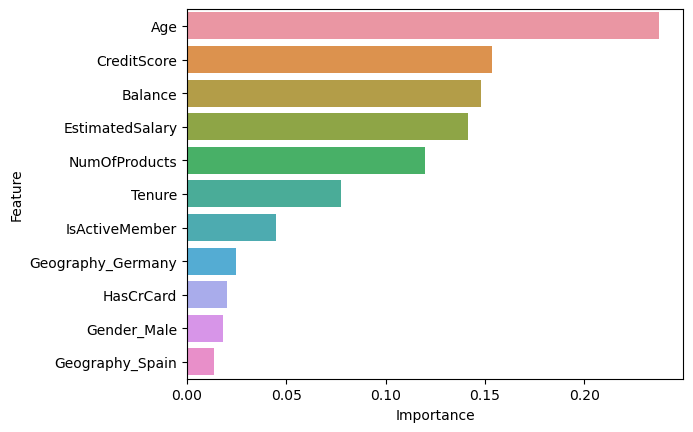

In [59]:
feature_imp = feature_imp.sort_values('Importance',ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.show()

In [60]:
from sklearn.model_selection import GridSearchCV

In [61]:
tuned_paramaters = [{'criterion': ['entropy','gini'],
                     'max_depth': [3,5,6,7]}]

In [62]:
dt = DecisionTreeClassifier(random_state = 10)
tree_grid = GridSearchCV(estimator = dt, 
                         param_grid = tuned_paramaters,
                         cv = 5)

In [63]:
tree_grid_model = tree_grid.fit(xtrain, ytrain)
tree_grid_model.best_params_

{'criterion': 'gini', 'max_depth': 7}

In [64]:
ypred_dt_tp = tree_grid_model.predict(xtest)

In [65]:
print('Train Accuracy',tree_grid_model.score(xtrain,ytrain))
print('Test Accuracy',tree_grid_model.score(xtest,ytest))

Train Accuracy 0.8780677834047527
Test Accuracy 0.8546209761163032


**Lets Look at Other Hyparameters**

In [66]:
tuned_paramaters = [{'criterion': ['entropy','gini'],
                     'max_depth': [5,10],  # 5,6,7,
                     'max_features': ["sqrt", "log2"], # it can be either square root of the feature or log of number of features
                    # 'min_samples_split': [2,5,8], # 1-3% of the total records
                    # 'min_samples_leaf': [1,5,9], # 1-3% of the min_sample_split
                     'max_leaf_nodes': [5,8]}]

In [67]:
dt = DecisionTreeClassifier(random_state = 10)

tree_grid = GridSearchCV(estimator = dt, # The estimator can be is logistic, Linear reg, decision tree
                         param_grid = tuned_paramaters,
                         cv = 5)

In [68]:
tree_grid_model = tree_grid.fit(xtrain, ytrain)
print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifier:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 8} 



In [69]:
dt_grid_model = DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 5,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 5,
                                  min_samples_leaf = 9,
                                  min_samples_split = 2,
                                  random_state = 10)

In [70]:
dt_grid_model= dt_grid_model.fit(xtrain,ytrain)

In [71]:
ypred_dt_tp = dt_grid_model.predict(xtest)

print(accuracy_score(ytest,ypred_dt_tp))
print(confusion_matrix(ytest,ypred_dt_tp))
print(classification_report(ytest,ypred_dt_tp))

0.8317757009345794
[[1446  108]
 [ 216  156]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1554
           1       0.59      0.42      0.49       372

    accuracy                           0.83      1926
   macro avg       0.73      0.67      0.69      1926
weighted avg       0.82      0.83      0.82      1926



In [72]:
print('Train Accuracy',tree_grid_model.score(xtrain,ytrain))
print('Test Accuracy',tree_grid_model.score(xtest,ytest))

Train Accuracy 0.8400207765225295
Test Accuracy 0.8483904465212876


1.The model performance is 83%.


In [73]:
ypred_dt_dp_train = tree_grid_model.predict(xtrain)

In [74]:
print(classification_report(ytrain,ypred_dt_dp_train))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      6123
           1       0.70      0.38      0.50      1578

    accuracy                           0.84      7701
   macro avg       0.78      0.67      0.70      7701
weighted avg       0.83      0.84      0.82      7701



In [75]:
# evaluate using confusion matrix.

print(confusion_matrix(ytest,ypred_dt_tp))

[[1446  108]
 [ 216  156]]


In [76]:
print(classification_report(ytest,ypred_dt_tp))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1554
           1       0.59      0.42      0.49       372

    accuracy                           0.83      1926
   macro avg       0.73      0.67      0.69      1926
weighted avg       0.82      0.83      0.82      1926



In [77]:
print(classification_report(ytest,ypred_dt_tp))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1554
           1       0.59      0.42      0.49       372

    accuracy                           0.83      1926
   macro avg       0.73      0.67      0.69      1926
weighted avg       0.82      0.83      0.82      1926



### Lets Summarize the Findings

In [78]:
update_performance(name = 'Decision Tree-Tuned', 
                   model = dt_grid_model,
                   test=ytest,
                   pred=ypred_dt_tp)
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566


**Gaussian Naive Bayes**

In [79]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

In [80]:
gnb = GaussianNB()
gnb.fit(xtrain,ytrain)
ypred_gnb = gnb.predict(xtest)

In [81]:
update_performance(name = 'Gaussian NB', 
                   model = gnb,
                   test=ytest,
                   pred=ypred_gnb)
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158


**Bernoulli NB**

In [82]:
bnb = BernoulliNB()
bnb.fit(xtrain,ytrain)

ypred_bnb = bnb.predict(xtest)

print(accuracy_score(ytest,ypred_bnb))
print(confusion_matrix(ytest,ypred_bnb))
print(classification_report(ytest,ypred_bnb))

0.7975077881619937
[[1487   67]
 [ 323   49]]
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1554
           1       0.42      0.13      0.20       372

    accuracy                           0.80      1926
   macro avg       0.62      0.54      0.54      1926
weighted avg       0.74      0.80      0.75      1926



In [83]:
update_performance(name = 'Bernoulli NB', model = bnb,test=ytest,pred=ypred_bnb)

# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820


**Multinomial Naive Bayes**

In [84]:
mnb = MultinomialNB()

mnb.fit(xtrain,ytrain)


ypred_mnb = mnb.predict(xtest)

print(accuracy_score(ytest,ypred_mnb))
print(confusion_matrix(ytest,ypred_mnb))
print(classification_report(ytest,ypred_mnb))

0.5311526479750779
[[827 727]
 [176 196]]
              precision    recall  f1-score   support

           0       0.82      0.53      0.65      1554
           1       0.21      0.53      0.30       372

    accuracy                           0.53      1926
   macro avg       0.52      0.53      0.47      1926
weighted avg       0.71      0.53      0.58      1926



In [85]:
update_performance(name = 'Multinomial NB', model = mnb,test=ytest,pred=ypred_mnb)

# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703


### Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
rf = RandomForestClassifier(random_state=10)
rf.fit(xtrain,ytrain)
ypred_rf = rf.predict(xtest)

In [88]:
# print(accuracy_score(ytest,ypred_rf))
# print(confusion_matrix(ytest,ypred_rf))
# print(classification_report(ytest,ypred_rf))


1. There are 2 ways at looking whether the model is overfit or underfit models
2. By using classification report or using score function

In [89]:
print('Train Accuracy',rf.score(xtrain,ytrain))
print('Test Accuracy',rf.score(xtest,ytest))

Train Accuracy 0.9998701467341904
Test Accuracy 0.8629283489096573


1. The model is still overfitting even when we have 100 trees.

In [90]:
update_performance(name = 'Random Forest', 
                   model = rf,
                   test=ytest,
                   pred=ypred_rf)
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462


**OOB SAMPLE -PERFORMANCE**

In [91]:
rf = RandomForestClassifier(oob_score=True, random_state=10)

rf.fit(xtrain,ytrain)

ypred_rf = rf.predict(xtest)
print(accuracy_score(ytest,ypred_rf))

print(rf.oob_score_)


0.8629283489096573
0.8567718478119725


**Is there a scope for Improvement -Lets Fine Tune the performance of Random Forest**

In [92]:
params =             [{'criterion': ['entropy', 'gini'],
                     #'n_estimators': [100],
                     'max_depth': [10, 15],
                     #'max_features': ['sqrt', 'log2'],
                    # 'min_samples_split': [2, 8],
                     #'min_samples_leaf': [5, 9],
                     'max_leaf_nodes': [8, 11]}]

In [93]:
rf =RandomForestClassifier(random_state=10)

rf_cv = GridSearchCV(rf,params,cv=5,scoring='accuracy')

rf_cv.fit(xtrain,ytrain)

rf_cv.best_params_

{'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 11}

In [94]:

rf_model = RandomForestClassifier(criterion ='entropy' ,
                                  n_estimators =10 ,
                                  max_depth = 10 ,
                                  max_features = 'sqrt',
                                  max_leaf_nodes =8 ,
                                  min_samples_leaf =5 ,
                                  min_samples_split = 2,
                                  random_state = 10)


rf_model.fit(xtrain,ytrain)

ypred_rf_tp = rf_model.predict(xtest)

print(accuracy_score(ytest,ypred_rf_tp))
print(confusion_matrix(ytest,ypred_rf_tp))
print(classification_report(ytest,ypred_rf_tp))

0.839563862928349
[[1535   19]
 [ 290   82]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1554
           1       0.81      0.22      0.35       372

    accuracy                           0.84      1926
   macro avg       0.83      0.60      0.63      1926
weighted avg       0.84      0.84      0.80      1926



Summarize the performance

In [95]:
update_performance(name = 'Random Forest-Tunned', model = rf_model,test=ytest,pred=ypred_rf_tp)

# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723


### Bagging Classifier

In [96]:
from sklearn.ensemble import BaggingClassifier
dt=DecisionTreeClassifier(random_state=10)
bc=BaggingClassifier(dt) # by default the estimator is Decision Tree
bc.fit(xtrain,ytrain)
ypred_bc = bc.predict(xtest)

#print(accuracy_score(ytest,ypred_bc))

Summarizing the performance

In [97]:
update_performance(name = 'Bagging Classifier-dt', 
                   model = bc,
                   test=ytest,
                   pred=ypred_bc)
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723


### KNN MODEL AS base model

In [98]:
from sklearn.ensemble import BaggingClassifier

knn=KNeighborsClassifier()

bag_knn=BaggingClassifier(knn,random_state=10) # by default the estimator is Decision Tree
bag_knn.fit(xtrain,ytrain)

ypred_bag_knn = bag_knn.predict(xtest)

print(accuracy_score(ytest,ypred_bag_knn))

0.7653167185877466


1. The model performance has improved compared to RF and Decision Tree
2. We have to run several models and then check the performance

Summarizing the performance

In [99]:
update_performance(name = 'Bagging Classifier-knn', model = bag_knn,test=ytest,pred=ypred_bag_knn)

# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723


### Bagging -LR Model. LR as base model

In [100]:

logr=LogisticRegression()

bag_logr=BaggingClassifier(logr,random_state=10) # by default the estimator is Decision Tree
bag_logr.fit(xtrain,ytrain)

ypred_bag_logr = bag_logr.predict(xtest)

print(accuracy_score(ytest,ypred_bag_logr))

0.8094496365524403


Summarizing the performance

In [101]:
update_performance(name = 'Bagging Classifier-Log', model = bag_logr,test=ytest,pred=ypred_bag_logr)

# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723


**Ensemble Learning- AdaBoosting**

In [102]:
from sklearn.ensemble  import AdaBoostClassifier

In [103]:
abcl = AdaBoostClassifier(random_state=10)
abcl.fit(xtrain,ytrain)

ypred_abcl = abcl.predict(xtest)
#print(accuracy_score(ytest,ypred_abcl))

In [104]:
update_performance(name = 'AdaBoost-dt', 
                   model = abcl,
                   test=ytest,
                   pred=ypred_abcl)
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723


In [105]:
from imblearn.over_sampling import SMOTE

In [106]:
smote = SMOTE(sampling_strategy=0.50,random_state = 10)
xtrain_sm, ytrain_sm = smote.fit_resample(xtrain,ytrain)

In [107]:
xtrain_sm.shape

(9184, 11)

#### Logistic Regression - SMOTE

In [108]:
lr_smote = LogisticRegression()
lr_smote.fit(xtrain_sm, ytrain_sm)
y_pred_lr_smote= lr_smote.predict(xtest)

In [109]:
update_performance(name = 'LogisticReg-Base-Smote', 
                   model = lr_smote,
                   test=ytest,
                   pred=y_pred_lr_smote)
# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723


Ensemble Learning - Gradient Boosting

In [110]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators=50,random_state=10)
gbcl.fit(xtrain,ytrain)
ypred_gbcl = gbcl.predict(xtest)
print(accuracy_score(ytest,ypred_gbcl))

0.867601246105919


In [111]:
gbcl = GradientBoostingClassifier(n_estimators=50,learning_rate=0.5,random_state=10,max_depth=3)
gbcl.fit(xtrain,ytrain)
ypred_gbcl = gbcl.predict(xtest)
print(accuracy_score(ytest,ypred_gbcl))

0.8582554517133957


In [112]:
gbcl = GradientBoostingClassifier(n_estimators=50,learning_rate=0.5,
                                  random_state=10,max_depth=3)
gbcl.fit(xtrain,ytrain)
ypred_gbcl = gbcl.predict(xtest)
print(accuracy_score(ytest,ypred_gbcl))

0.8582554517133957


Summarizing the performance

In [113]:
update_performance(name = 'Gradient Boosting', 
                   model = gbcl,
                   test=ytest,
                   pred=ypred_gbcl)

# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723


XGBOOST

In [114]:
# !pip install xgboost

In [115]:
from xgboost import XGBClassifier

In [116]:
xgb= XGBClassifier(random_state=10)
xgb.fit(xtrain,ytrain)

ypred_xgb= xgb.predict(xtest)
print(accuracy_score(ytest,ypred_xgb))

0.8525441329179647


In [117]:
xgb= XGBClassifier(booster='gbtree',gamma=3,max_depth=3, min_child_weight=3,
                   n_estimators=50, reg_lambda=1,random_state=10)
xgb.fit(xtrain,ytrain)


ypred_xgb= xgb.predict(xtest)
print(accuracy_score(ytest,ypred_xgb))

0.8655244029075805


Summarizing the performance

In [118]:
update_performance(name = 'XGB', model = xgb,test=ytest,pred=ypred_xgb)

# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723


### STACKING

In [119]:
from sklearn.ensemble import StackingClassifier

In [120]:
lr=LogisticRegression()
knn=KNeighborsClassifier()
dt=DecisionTreeClassifier()

In [121]:
base_learners=[('lr_model',lr),('knn_model',knn),('DT_model',dt)]

stack =StackingClassifier(estimators=base_learners,
                          final_estimator=GaussianNB())
stack.fit(xtrain,ytrain)
ypred_stack = stack.predict(xtest)
#print(accuracy_score(ytest,ypred_stack))

Summarizing the performance

In [122]:
update_performance(name = 'Stacking', model = stack,test=ytest,pred=ypred_stack)

# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723


### Voting Classifier

In [123]:
from sklearn.ensemble import VotingClassifier

In [124]:
vote_hard =VotingClassifier(estimators=base_learners )

vote_hard.fit(xtrain,ytrain)
ypred_vote = vote_hard.predict(xtest)
print(accuracy_score(ytest,ypred_vote))

0.8042575285565939


In [125]:
vote_soft =VotingClassifier(estimators=base_learners ,voting='soft')

vote_soft.fit(xtrain,ytrain)
ypred_vote = vote_soft.predict(xtest)
print(accuracy_score(ytest,ypred_vote))

0.8094496365524403


Summarizing the performance

In [126]:
update_performance(name = 'Voting', model = vote_soft,test=ytest,pred=ypred_vote)

# print the dataframe
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticReg-Base,0.806854,0.000000,0.000000,0.000000
1,KNN-Base,0.762201,0.088710,0.217105,0.125954
2,Decision Tree-Gini,0.792835,0.483871,0.465116,0.474308
3,Decision Tree-Entropy,0.790239,0.481183,0.458974,0.469816
4,Decision Tree-Tuned,0.831776,0.419355,0.590909,0.490566
5,Gaussian NB,0.812046,0.209677,0.534247,0.301158
6,Bernoulli NB,0.797508,0.131720,0.422414,0.200820
7,Multinomial NB,0.531153,0.526882,0.212351,0.302703
8,Random Forest,0.862928,0.454301,0.734783,0.561462
9,Random Forest-Tunned,0.839564,0.220430,0.811881,0.346723
